### Экспериментальное исследование алгоритмов для регулярных запросов

##### Постановка задачи:
`tensor_based_rpq` и `ms_bfs_based_rpq` — алгоритмы, реализованные в модуле `project.regular_path_query`, решающие задачу достижимости в графе с регулярными ограничениями на пути между вершинами. Цель данной работы — ответить на следующие исследовательские вопросы:

RQ1. При каком представлении разреженных матриц и векторов алгоритм показывают наилучшее время выполнения? 

RQ2. При каком размере стартового множества становится выгоднее по времени выполнить алгоритм для всех пар вершин с последующим выбором нужных вершин, чем непосредственное вычисление достижимости для заданного множества стартовых вершин?

##### Описание исследуемых решений:
Сигнатуры первоначальных решений:

```
def tensor_based_rpq(regex: str, graph: MultiDiGraph, start_nodes: set[int],
      final_nodes: set[int]) -> set[tuple[int, int]]:
   pass
```
Алгоритм на основе тензорного произведения. 

```
def ms_bfs_based_rpq(regex: str, graph: MultiDiGraph, start_nodes: set[int],
         final_nodes: set[int]) -> set[tuple[int, int]]:
  pass
```
Алгоритм на основе multiple-source BFS.

Для проведения эксперимента были реализованы версии алгоритмов, дополнительно принимающие параметр matrix_class.

#### Описание набора данных для экспериментов:

##### Запросы:
Для экспериментов использовались регулярные выражения, включающие все основные операции: замыкание, конкатенацию, альтернативу:
1. `(a | b)* c d+`,
2. `a (b | c)* d+`,
3. `((a | b)+ c)* d`,
4. `((c+) | a) b d*`

где a, b, c, d соответствуют четырём наиболее часто встречающимся меткам рёбер в графах.


##### Графы:
Для экспериментов использовались три графа из набора [CFPQ_data](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/index.html):

| Название графа | Вершины | Рёбра | 
| -------------- | ------- | ----- | 
| travel         | 131     | 277   |
| wine           | 733     | 1839  |
| funding        | 778     | 1086  | 

Выбор обусловлен следующими соображениями:
- Количество вершин и рёбер не слишком большое, что позволяет выполнить 25 запусков для каждой конфигурации эксперимента за разумное время (на тестовой машине это заняло чуть более 11 часов).
- travel — самый маленький по размеру граф, был выбран для отладки.
- wine и funding имеют сопоставимое количество вершин (733 и 778), но существенно различаются по числу рёбер (1839 и 1086), что приводит к различной плотности их матриц смежности. Это позволяет протестировать алгоритмы как на более плотных, так и на более разреженных структурах данных.
- Наличие не менее четырёх различных меток — из-за выбранных регулярных выражений.

#### Описание эксперимента:


##### Оборудование:
MacBook Air, процессор Apple M1, 8 ядер, 8 GB памяти, macOS Sequoia 15.5. Python 3.13.5

##### Ход эксперимента:


In [525]:
import sys
import os

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), ".."))
from project.graph_utils import get_graph_data, get_graph_by_name
from project.regular_path_query import tensor_based_rpq, ms_bfs_based_rpq
from scipy import sparse
import cfpq_data

Были выбраны следующие представления разрезженных матриц из `scipy.sparse`. Формирование множества стартовых вершин осуществляется функцией [generate_multiple_source](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/reference/graphs/generated/cfpq_data.graphs.utils.multiple_source_utils.html#cfpq_data.graphs.utils.multiple_source_utils.generate_multiple_source). Количество запусков для каждого уникального набора параметров — 25.

In [526]:
MATRIX_TYPES = [
    sparse.csr_matrix,
    sparse.csc_matrix,
    sparse.lil_matrix,
    sparse.coo_matrix,
]

ALGORITHMS = [tensor_based_rpq, ms_bfs_based_rpq]
RUN_COUNT = 25
START_SET_FRACTIONS = [1, 0.7, 0.5, 0.3, 0.1]

In [527]:
def generate_start_set(graph, fraction):
    if fraction == 1:
        return set()
    nodes_count = max(1, int(graph.number_of_nodes() * fraction))
    return cfpq_data.generate_multiple_source(graph, nodes_count, seed=52)


def label_set_to_regexes(labels):
    a = labels[0]
    b = labels[1]
    c = labels[2]
    d = labels[3]
    return (
        f"({a} | {b})* {c} {d}+",
        f"{a} ({b} | {c})* {d}+",
        f"(({a} | {b})+ {c})* {d}",
        f"(({c}+) | {a}) {b} {d}*",
    )

In [528]:
gtravel = get_graph_by_name("travel")
gwine = get_graph_by_name("wine")
gfunding = get_graph_by_name("funding")
GRAPHS = {"travel": gtravel, "wine": gwine, "funding": gfunding}

[2025-10-14 15:15:35]>INFO>Found graph with name='travel'
[2025-10-14 15:15:35]>INFO>Load archive graph_archive=PosixPath('/Users/vicat/Study/uni/fifth/formal-lang-course/formlang/lib/python3.13/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2025-10-14 15:15:35]>INFO>Unzip graph name='travel' to file graph=PosixPath('/Users/vicat/Study/uni/fifth/formal-lang-course/formlang/lib/python3.13/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2025-10-14 15:15:35]>INFO>Remove archive graph_archive=PosixPath('/Users/vicat/Study/uni/fifth/formal-lang-course/formlang/lib/python3.13/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2025-10-14 15:15:35]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x13fe8c2d0> from path=PosixPath('/Users/vicat/Study/uni/fifth/formal-lang-course/formlang/lib/python3.13/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2025-10-14 15:15:35]>INFO>Found graph with name='wine'
[2025-10-14 15:15:35]>INFO>Load archive graph_

In [529]:
REGEXES = {}


def generate_regexes(gname):
    # getting most popular 4 labels
    labels_set = get_graph_data(gname).attributes
    popular_labels = sorted(labels_set)[:4]
    return label_set_to_regexes(popular_labels)


for gname, _ in GRAPHS.items():
    REGEXES[gname] = generate_regexes(gname)

[2025-10-14 15:15:35]>INFO>Found graph with name='travel'
[2025-10-14 15:15:35]>INFO>Load archive graph_archive=PosixPath('/Users/vicat/Study/uni/fifth/formal-lang-course/formlang/lib/python3.13/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2025-10-14 15:15:35]>INFO>Unzip graph name='travel' to file graph=PosixPath('/Users/vicat/Study/uni/fifth/formal-lang-course/formlang/lib/python3.13/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2025-10-14 15:15:35]>INFO>Remove archive graph_archive=PosixPath('/Users/vicat/Study/uni/fifth/formal-lang-course/formlang/lib/python3.13/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2025-10-14 15:15:35]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x1656d22b0> from path=PosixPath('/Users/vicat/Study/uni/fifth/formal-lang-course/formlang/lib/python3.13/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2025-10-14 15:15:35]>INFO>Found graph with name='wine'
[2025-10-14 15:15:35]>INFO>Load archive graph_

In [530]:
def get_regex_template(regex_num):
    if regex_num == 0:
        return "(a | b)* c d+"
    elif regex_num == 1:
        return "a (b | c)* d+"
    elif regex_num == 2:
        return "((a | b)+ c)* d"
    else:
        return "((c+) | a) b d*"

In [531]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
from itertools import product
from scipy import stats

Результаты замеров лежат в директории experiment_out.

In [532]:
OUTPUT_DIR = "experiment_out"
os.makedirs(OUTPUT_DIR, exist_ok=True)
RESULTS_FILE = os.path.join(OUTPUT_DIR, "experiment_res.csv")


def get_new_path(file_name):
    return os.path.join(OUTPUT_DIR, file_name)

Замер времени осуществляется функцией `measure_time`, которая использует `time.perf_counter()`. Эксперимент выполняется функцией `run_experiment_for_graph`, в которой перебираются все комбинации параметров.

In [533]:
def measure_time(graph, regex, start_nodes, matrix_type, algo):
    t0 = time.perf_counter()
    try:
        algo(
            regex=regex,
            graph=graph,
            start_nodes=start_nodes,
            final_nodes=set(),
            matrix_class=matrix_type,
        )
    except Exception as e:
        print(f"ERROR in algo call: {e}")
        print(f"Algo details: {algo}")
        raise

    t1 = time.perf_counter()
    return t1 - t0


def run_experiment_for_graph(gname, file_name):
    graph = GRAPHS[gname]
    results = []
    for frac in START_SET_FRACTIONS:
        start_nodes = generate_start_set(graph, frac)
        for run in range(RUN_COUNT):
            for matrix_type, algo, regex in product(
                MATRIX_TYPES, ALGORITHMS, REGEXES[gname]
            ):
                matrix_type_name = matrix_type.__name__
                algo_name = algo.__name__
                elapsed = measure_time(graph, regex, start_nodes, matrix_type, algo)
                record = {
                    "graph": gname,
                    "regex": regex,
                    "matrix_type": matrix_type_name,
                    "algorithm": algo_name,
                    "fraction": frac,
                    "run": run,
                    "time": elapsed,
                    "start_set_size": len(start_nodes),
                }
                results.append(record)

                df = pd.DataFrame([record])
                df.to_csv(file_name, mode="a", index=False, header=False)
    return results


def run_all_experiments(file):
    all_results = []
    for gname in GRAPHS.keys():
        gresults = run_experiment_for_graph(gname, file)
        all_results.extend(gresults)

    return pd.DataFrame(all_results)

In [ ]:
main_results_df = run_all_experiments(RESULTS_FILE)

Проанализируем полученные данные.

In [621]:
#  Получить данные из файла
main_results_df = pd.read_csv(RESULTS_FILE)
main_results_df.columns = [
    "graph",
    "regex",
    "matrix_type",
    "algorithm",
    "fraction",
    "run",
    "time",
    "start_set_size",
]

### RQ1 

Для определения оптимального представления разреженных матриц выполнены:

1. Сбор статистики:
   - Базовые метрики: среднее время, стандартное отклонение, минимум/максимум
   - Проверка критериев нормальности, вычисление коэффициентов вариации (стандартного отклонения относительно среднего времени), вычисление доверительных интервалов, подсчёт количества выбросов

2. Сравнение:
   - Определение лучшего и худшего типа матриц для каждого сценария
   - Количественная оценка преимущества (% выигрыша)

3. Составлены boxplot-диаграммы для сравнения распределений времени выполнения

In [648]:
def get_stat(group):
    t = group["time"].values

    Q1 = np.percentile(t, 25)
    Q3 = np.percentile(t, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = [x for x in t if x < lower_bound or x > upper_bound]

    normality_results = []
    for regex in group["regex"].unique():
        regex_times = group[group["regex"] == regex]["time"].values

        _, nt_res = stats.normaltest(regex_times)
        is_normal1 = nt_res > 0.05

        _, shapiro_res = stats.shapiro(regex_times)
        is_normal2 = shapiro_res > 0.05

        normality_for_regex = is_normal1 or is_normal2
        normality_results.append(normality_for_regex)

    normality_passed = all(normality_results) if normality_results else False

    rel = (np.std(t, ddof=1) / np.mean(t)) * 100
    ci = stats.t.ppf(0.975, df=len(t) - 1) * stats.sem(t)

    return pd.Series(
        {
            "count": len(t),
            "mean": np.mean(t),
            "std": np.std(t, ddof=1),
            "min": np.min(t),
            "max": np.max(t),
            "variation_coeff": f"{rel:.2f}%",
            "CI": f"{ci:.6f}",
            "normal": normality_passed,
            "outliers": len(outliers),
        }
    )

In [650]:
def show_stat_RQ1(algo, gname, df):
    dfg = df[(df["algorithm"] == f"{algo}") & (df["graph"] == f"{gname}")].copy()
    stats_table = (
        dfg.groupby(["fraction", "matrix_type"])
        .apply(get_stat, include_groups=False)
        .round(6)
    )

    dfg["fraction"] = dfg["fraction"].astype(float)
    dfg["time"] = dfg["time"].astype(float)

    print(f"\nНаибольшее среднее по долям стартовых вершин:")
    for fraction in START_SET_FRACTIONS:
        fraction_stats = stats_table.loc[fraction]

        best_type = fraction_stats["mean"].idxmin()
        best_time = fraction_stats.loc[best_type, "mean"]

        worst_type = fraction_stats["mean"].idxmax()
        worst_time = fraction_stats.loc[worst_type, "mean"]
        improvement = (worst_time - best_time) / worst_time * 100

        print(
            f"Доля {fraction:.1f}: {best_type} ({best_time:.6f} сек) "
            f"- выигрыш относительно худшего {improvement:.2f}%"
        )

    plt.figure(figsize=(15, 8))

    sns.boxplot(
        data=dfg,
        x="fraction",
        y="time",
        hue="matrix_type",
        order=START_SET_FRACTIONS,
        showfliers=True,
    )

    plt.xlabel("Доля стартовых вершин")
    plt.ylabel("Время (сек)")
    plt.title(f"{algo}: Сравнение типов матриц")
    plt.legend(title="Тип матрицы", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    return stats_table

#### Проанализируем результаты вычислений для `tensor_based_rpq`:

[2025-10-14 17:32:05]>INFO>Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-10-14 17:32:05]>INFO>Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



Наибольшее среднее по долям стартовых вершин:
Доля 1.0: coo_matrix (0.175070 сек) - выигрыш относительно худшего 1.76%
Доля 0.7: coo_matrix (0.124233 сек) - выигрыш относительно худшего 4.33%
Доля 0.5: coo_matrix (0.091806 сек) - выигрыш относительно худшего 3.04%
Доля 0.3: coo_matrix (0.058708 сек) - выигрыш относительно худшего 4.60%
Доля 0.1: coo_matrix (0.025590 сек) - выигрыш относительно худшего 7.84%


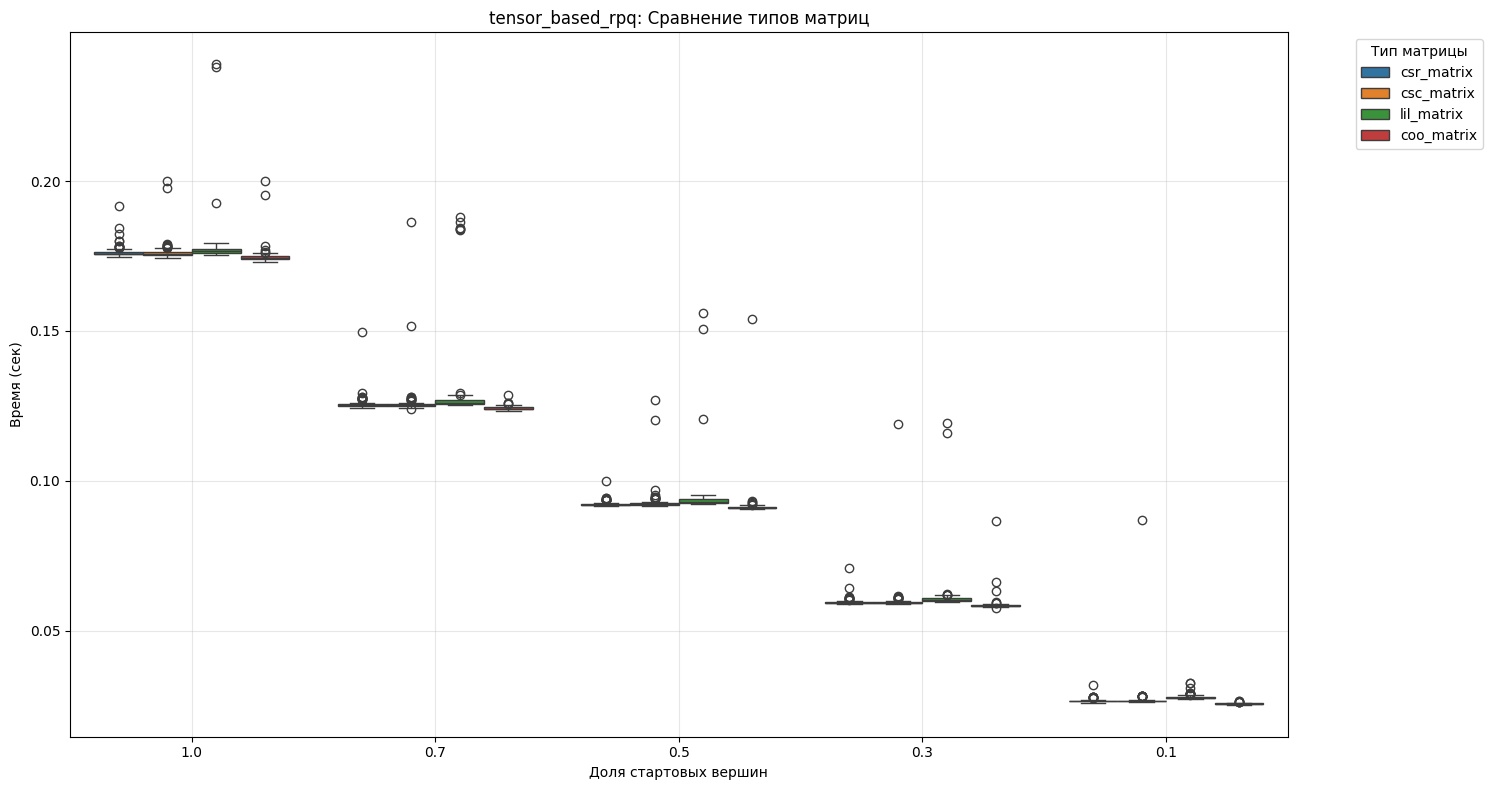

count      mean       std       min       max  \
fraction matrix_type                                                  
0.1      coo_matrix     100  0.025590  0.000215  0.025236  0.026400   
         csc_matrix     100  0.027206  0.006064  0.026120  0.087032   
         csr_matrix     100  0.026594  0.000666  0.025934  0.031919   
         lil_matrix     100  0.027768  0.000911  0.026992  0.032589   
0.3      coo_matrix     100  0.058708  0.002984  0.057664  0.086610   
         csc_matrix     100  0.059993  0.005980  0.058754  0.118959   
         csr_matrix     100  0.059552  0.001334  0.058702  0.070795   
         lil_matrix     100  0.061538  0.008080  0.059570  0.119363   
0.5      coo_matrix     100  0.091806  0.006311  0.090573  0.154123   
         csc_matrix     100  0.092981  0.004510  0.091505  0.127092   
         csr_matrix     100  0.092294  0.000955  0.091457  0.099788   
         lil_matrix     100  0.094689  0.008895  0.092213  0.155990   
0.7      coo_matrix     100  0.124233  0.000691  0.123276  0.128675   
         csc_matrix     100  0.126304  0.006652  0.124101  0.186404   
         csr_matrix     100  0.125667  0.002568  0.124307  0.149601   
         lil_matrix     100  0.129858  0.014052  0.125162  0.187923   
1.0      coo_matrix     100  0.175070  0.003372  0.173172  0.200223   
         csc_matrix     100  0.176359  0.003382  0.174382  0.199998   
         csr_matrix     100  0.176350  0.002107  0.174770  0.191744   
         lil_matrix     100  0.178204  0.008862  0.175220  0.239015   

                     variation_coeff        CI  normal  outliers  
fraction matrix_type                                              
0.1      coo_matrix            0.84%  0.000043   False         6  
         csc_matrix           22.29%  0.001203   False        10  
         csr_matrix            2.50%  0.000132   False         9  
         lil_matrix            3.28%  0.000181   False        13  
0.3      coo_matrix            5.08%  0.000592   False         7  
         csc_matrix            9.97%  0.001187   False        10  
         csr_matrix            2.24%  0.000265   False        11  
         lil_matrix           13.13%  0.001603   False         6  
0.5      coo_matrix            6.87%  0.001252   False         6  
         csc_matrix            4.85%  0.000895   False        12  
         csr_matrix            1.03%  0.000189   False        11  
         lil_matrix            9.39%  0.001765   False         3  
0.7      coo_matrix            0.56%  0.000137   False         4  
         csc_matrix            5.27%  0.001320   False        12  
         csr_matrix            2.04%  0.000510   False        12  
         lil_matrix           10.82%  0.002788   False         8  
1.0      coo_matrix            1.93%  0.000669   False         6  
         csc_matrix            1.92%  0.000671   False        11  
         csr_matrix            1.19%  0.000418   False        12  
         lil_matrix            4.97%  0.001758   False         3

In [651]:
travel_tb_df = show_stat_RQ1("tensor_based_rpq", "travel", main_results_df)
travel_tb_df

[2025-10-14 17:32:09]>INFO>Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-10-14 17:32:09]>INFO>Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



Наибольшее среднее по долям стартовых вершин:
Доля 1.0: coo_matrix (5.207980 сек) - выигрыш относительно худшего 0.63%
Доля 0.7: coo_matrix (3.654134 сек) - выигрыш относительно худшего 0.55%
Доля 0.5: coo_matrix (2.620682 сек) - выигрыш относительно худшего 0.75%
Доля 0.3: coo_matrix (1.585991 сек) - выигрыш относительно худшего 1.68%
Доля 0.1: coo_matrix (0.561620 сек) - выигрыш относительно худшего 4.57%


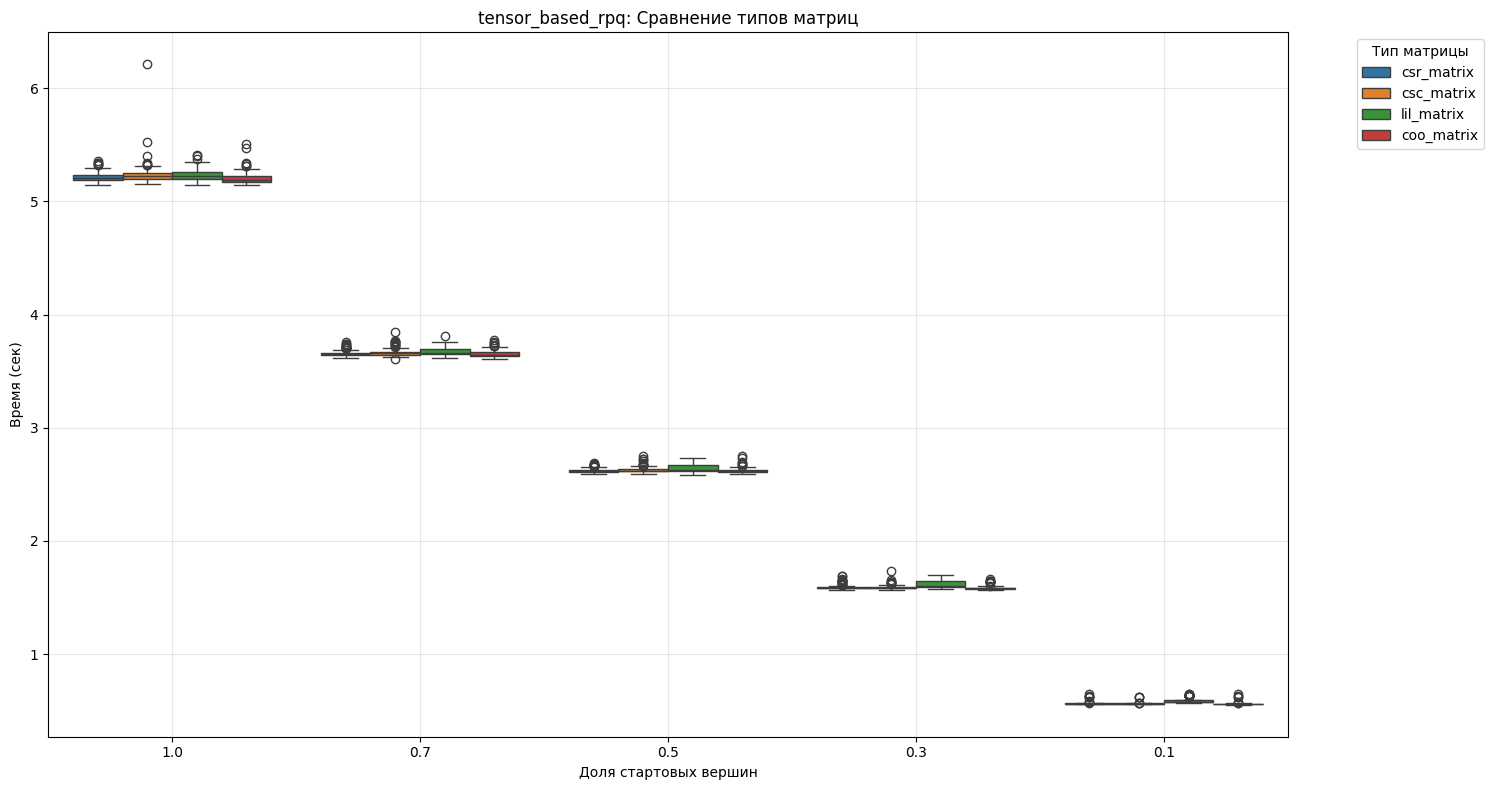

count      mean       std       min       max  \
fraction matrix_type                                                  
0.1      coo_matrix     100  0.561620  0.014107  0.552061  0.645774   
         csc_matrix     100  0.563317  0.010004  0.556614  0.618624   
         csr_matrix     100  0.565246  0.015232  0.554858  0.649777   
         lil_matrix     100  0.588535  0.027416  0.565813  0.644426   
0.3      coo_matrix     100  1.585991  0.019156  1.565786  1.661615   
         csc_matrix     100  1.592466  0.020835  1.568582  1.732301   
         csr_matrix     100  1.593596  0.024206  1.567894  1.692469   
         lil_matrix     100  1.613132  0.030892  1.576560  1.697976   
0.5      coo_matrix     100  2.620682  0.026563  2.589087  2.747628   
         csc_matrix     100  2.630006  0.026672  2.590703  2.747866   
         csr_matrix     100  2.623723  0.020556  2.594011  2.685006   
         lil_matrix     100  2.640365  0.033238  2.581087  2.735293   
0.7      coo_matrix     100  3.654134  0.035384  3.605675  3.773059   
         csc_matrix     100  3.667964  0.036355  3.604917  3.844020   
         csr_matrix     100  3.659255  0.028791  3.615719  3.761829   
         lil_matrix     100  3.674499  0.037428  3.618646  3.811003   
1.0      coo_matrix     100  5.207980  0.059374  5.142619  5.506070   
         csc_matrix     100  5.240980  0.111439  5.153908  6.212105   
         csr_matrix     100  5.218274  0.043029  5.142930  5.353737   
         lil_matrix     100  5.234024  0.052042  5.141549  5.407090   

                     variation_coeff        CI  normal  outliers  
fraction matrix_type                                              
0.1      coo_matrix            2.51%  0.002799   False         7  
         csc_matrix            1.78%  0.001985   False         6  
         csr_matrix            2.69%  0.003022   False         8  
         lil_matrix            4.66%  0.005440   False        25  
0.3      coo_matrix            1.21%  0.003801   False        10  
         csc_matrix            1.31%  0.004134   False         9  
         csr_matrix            1.52%  0.004803   False        16  
         lil_matrix            1.92%  0.006130   False         0  
0.5      coo_matrix            1.01%  0.005271   False         8  
         csc_matrix            1.01%  0.005292   False        10  
         csr_matrix            0.78%  0.004079   False        12  
         lil_matrix            1.26%  0.006595   False         0  
0.7      coo_matrix            0.97%  0.007021   False         8  
         csc_matrix            0.99%  0.007214   False        12  
         csr_matrix            0.79%  0.005713   False        14  
         lil_matrix            1.02%  0.007426   False         1  
1.0      coo_matrix            1.14%  0.011781   False         6  
         csc_matrix            2.13%  0.022112   False         7  
         csr_matrix            0.82%  0.008538   False         6  
         lil_matrix            0.99%  0.010326   False         3

In [652]:
wine_tb_df = show_stat_RQ1("tensor_based_rpq", "wine", main_results_df)
wine_tb_df

[2025-10-14 17:32:12]>INFO>Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-10-14 17:32:12]>INFO>Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



Наибольшее среднее по долям стартовых вершин:
Доля 1.0: lil_matrix (5.813473 сек) - выигрыш относительно худшего 0.54%
Доля 0.7: lil_matrix (4.086845 сек) - выигрыш относительно худшего 0.33%
Доля 0.5: coo_matrix (2.956466 сек) - выигрыш относительно худшего 0.43%
Доля 0.3: coo_matrix (1.796254 сек) - выигрыш относительно худшего 0.94%
Доля 0.1: csr_matrix (0.618736 сек) - выигрыш относительно худшего 3.15%


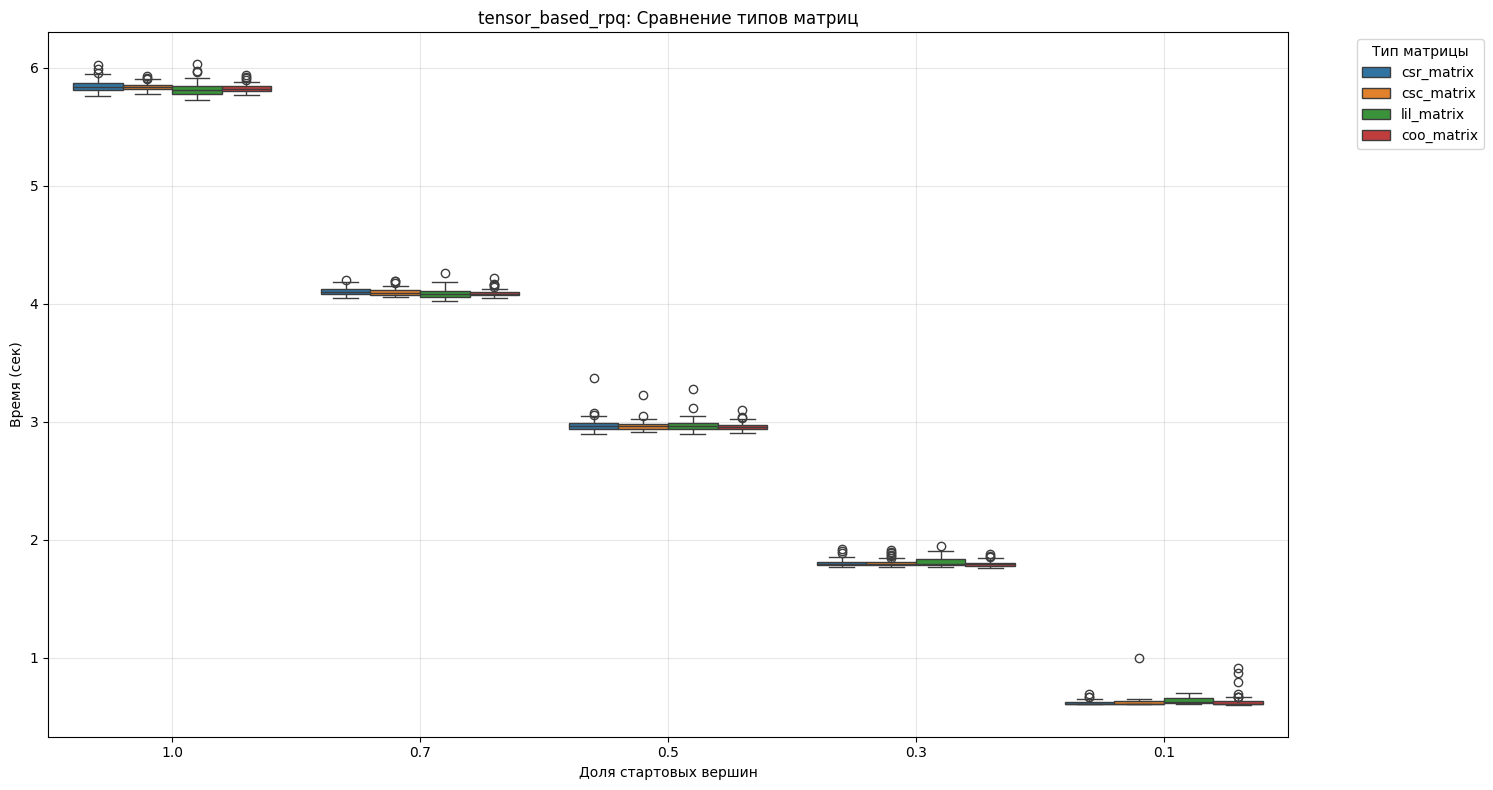

count      mean       std       min       max  \
fraction matrix_type                                                  
0.1      coo_matrix     100  0.625229  0.046607  0.602813  0.914416   
         csc_matrix     100  0.622024  0.040138  0.605698  0.999045   
         csr_matrix     100  0.618736  0.016096  0.605426  0.694272   
         lil_matrix     100  0.638888  0.026521  0.611541  0.704045   
0.3      coo_matrix     100  1.796254  0.020816  1.764529  1.876862   
         csc_matrix     100  1.801327  0.025911  1.769908  1.913629   
         csr_matrix     100  1.803153  0.026041  1.772252  1.922764   
         lil_matrix     100  1.813325  0.034534  1.771051  1.943847   
0.5      coo_matrix     100  2.956466  0.030650  2.902896  3.098743   
         csc_matrix     100  2.963511  0.038108  2.910644  3.226886   
         csr_matrix     100  2.967604  0.053441  2.900338  3.374001   
         lil_matrix     100  2.969376  0.046971  2.899974  3.277226   
0.7      coo_matrix     100  4.086996  0.026801  4.044770  4.216939   
         csc_matrix     100  4.097652  0.028640  4.056373  4.189256   
         csr_matrix     100  4.100468  0.028531  4.048130  4.202560   
         lil_matrix     100  4.086845  0.044675  4.019213  4.260790   
1.0      coo_matrix     100  5.826137  0.030257  5.766951  5.939410   
         csc_matrix     100  5.837237  0.030205  5.779662  5.931548   
         csr_matrix     100  5.844818  0.044873  5.763112  6.019011   
         lil_matrix     100  5.813473  0.052719  5.722738  6.028154   

                     variation_coeff        CI  normal  outliers  
fraction matrix_type                                              
0.1      coo_matrix            7.45%  0.009248   False         7  
         csc_matrix            6.45%  0.007964   False         1  
         csr_matrix            2.60%  0.003194   False         3  
         lil_matrix            4.15%  0.005262   False         0  
0.3      coo_matrix            1.16%  0.004130   False         3  
         csc_matrix            1.44%  0.005141   False         6  
         csr_matrix            1.44%  0.005167   False         3  
         lil_matrix            1.90%  0.006852   False         1  
0.5      coo_matrix            1.04%  0.006082   False         3  
         csc_matrix            1.29%  0.007562   False         2  
         csr_matrix            1.80%  0.010604   False         3  
         lil_matrix            1.58%  0.009320   False         2  
0.7      coo_matrix            0.66%  0.005318   False         5  
         csc_matrix            0.70%  0.005683   False         3  
         csr_matrix            0.70%  0.005661   False         1  
         lil_matrix            1.09%  0.008864   False         1  
1.0      coo_matrix            0.52%  0.006004   False         4  
         csc_matrix            0.52%  0.005993   False         3  
         csr_matrix            0.77%  0.008904   False         3  
         lil_matrix            0.91%  0.010461   False         3

In [653]:
funding_tb_df = show_stat_RQ1("tensor_based_rpq", "funding", main_results_df)
funding_tb_df

##### Ответ на RQ1 для `tensor_based_rpq`
Зеализация `coo_matrix` демонстрирует преимущество для алгоритма `tensor_based_rpq`. В 13 из 15 тестовых сценариев (87%) `coo_matrix` показала наилучшую производительность, при этом максимальный выигрыш составил 7,84%. Для графа funding наблюдается незначительная вариативность результатов, но выигрыш других реализация не такой большой (максимальный -- у `csr_matrix`, 3,15%).

#### Проанализируем результаты вычислений для `ms_bfs_based_rpq`:

[2025-10-14 17:32:43]>INFO>Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-10-14 17:32:43]>INFO>Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



Наибольшее среднее по долям стартовых вершин:
Доля 1.0: csc_matrix (0.248540 сек) - выигрыш относительно худшего 14.41%
Доля 0.7: csc_matrix (0.176055 сек) - выигрыш относительно худшего 13.88%
Доля 0.5: csc_matrix (0.106231 сек) - выигрыш относительно худшего 13.25%
Доля 0.3: csc_matrix (0.067459 сек) - выигрыш относительно худшего 12.59%
Доля 0.1: csc_matrix (0.027068 сек) - выигрыш относительно худшего 9.27%


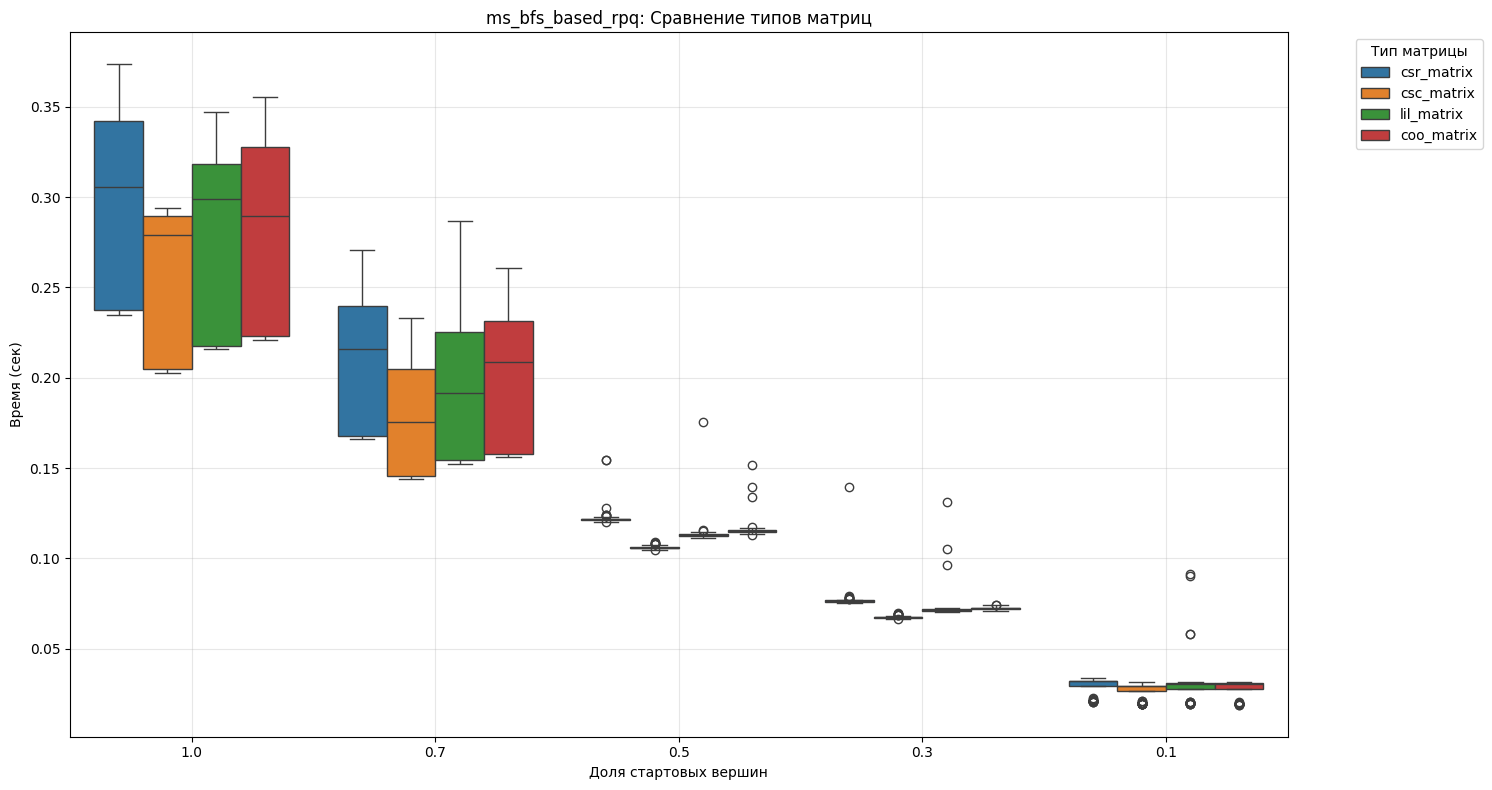

count      mean       std       min       max  \
fraction matrix_type                                                  
0.1      coo_matrix     100  0.027856  0.004922  0.019053  0.031577   
         csc_matrix     100  0.027068  0.004204  0.019519  0.031889   
         csr_matrix     100  0.029494  0.004841  0.020744  0.034039   
         lil_matrix     100  0.029832  0.010827  0.019586  0.091630   
0.3      coo_matrix     100  0.072450  0.000609  0.071156  0.074135   
         csc_matrix     100  0.067459  0.000661  0.066239  0.069945   
         csr_matrix     100  0.077177  0.006352  0.075394  0.139768   
         lil_matrix     100  0.072662  0.007266  0.070485  0.131221   
0.5      coo_matrix     100  0.115890  0.004810  0.112953  0.151771   
         csc_matrix     100  0.106231  0.000768  0.104524  0.109123   
         csr_matrix     100  0.122454  0.004725  0.120129  0.154723   
         lil_matrix     100  0.113569  0.006319  0.111411  0.175669   
0.7      coo_matrix     100  0.195215  0.037222  0.156159  0.260967   
         csc_matrix     100  0.176055  0.030873  0.143920  0.232873   
         csr_matrix     100  0.204419  0.036543  0.165965  0.270933   
         lil_matrix     100  0.190724  0.036808  0.152350  0.287023   
1.0      coo_matrix     100  0.276149  0.052808  0.220807  0.355567   
         csc_matrix     100  0.248540  0.042007  0.202604  0.294061   
         csr_matrix     100  0.290378  0.052902  0.234561  0.373470   
         lil_matrix     100  0.269700  0.050487  0.215659  0.347045   

                     variation_coeff        CI  normal  outliers  
fraction matrix_type                                              
0.1      coo_matrix           17.67%  0.000977   False        25  
         csc_matrix           15.53%  0.000834   False        25  
         csr_matrix           16.41%  0.000961   False        25  
         lil_matrix           36.29%  0.002148   False        29  
0.3      coo_matrix            0.84%  0.000121   False         2  
         csc_matrix            0.98%  0.000131   False        10  
         csr_matrix            8.23%  0.001260   False         9  
         lil_matrix           10.00%  0.001442   False         3  
0.5      coo_matrix            4.15%  0.000954   False         5  
         csc_matrix            0.72%  0.000152   False         8  
         csr_matrix            3.86%  0.000938   False         9  
         lil_matrix            5.56%  0.001254   False         3  
0.7      coo_matrix           19.07%  0.007386   False         0  
         csc_matrix           17.54%  0.006126   False         0  
         csr_matrix           17.88%  0.007251   False         0  
         lil_matrix           19.30%  0.007303   False         0  
1.0      coo_matrix           19.12%  0.010478   False         0  
         csc_matrix           16.90%  0.008335   False         0  
         csr_matrix           18.22%  0.010497   False         0  
         lil_matrix           18.72%  0.010018   False         0

In [654]:
travel_msbfs_df = show_stat_RQ1("ms_bfs_based_rpq", "travel", main_results_df)
travel_msbfs_df

[2025-10-14 17:32:46]>INFO>Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-10-14 17:32:46]>INFO>Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



Наибольшее среднее по долям стартовых вершин:
Доля 1.0: csc_matrix (1.161835 сек) - выигрыш относительно худшего 14.46%
Доля 0.7: csc_matrix (0.825265 сек) - выигрыш относительно худшего 13.83%
Доля 0.5: csc_matrix (0.539561 сек) - выигрыш относительно худшего 12.93%
Доля 0.3: csc_matrix (0.342715 сек) - выигрыш относительно худшего 12.00%
Доля 0.1: csc_matrix (0.150067 сек) - выигрыш относительно худшего 13.92%


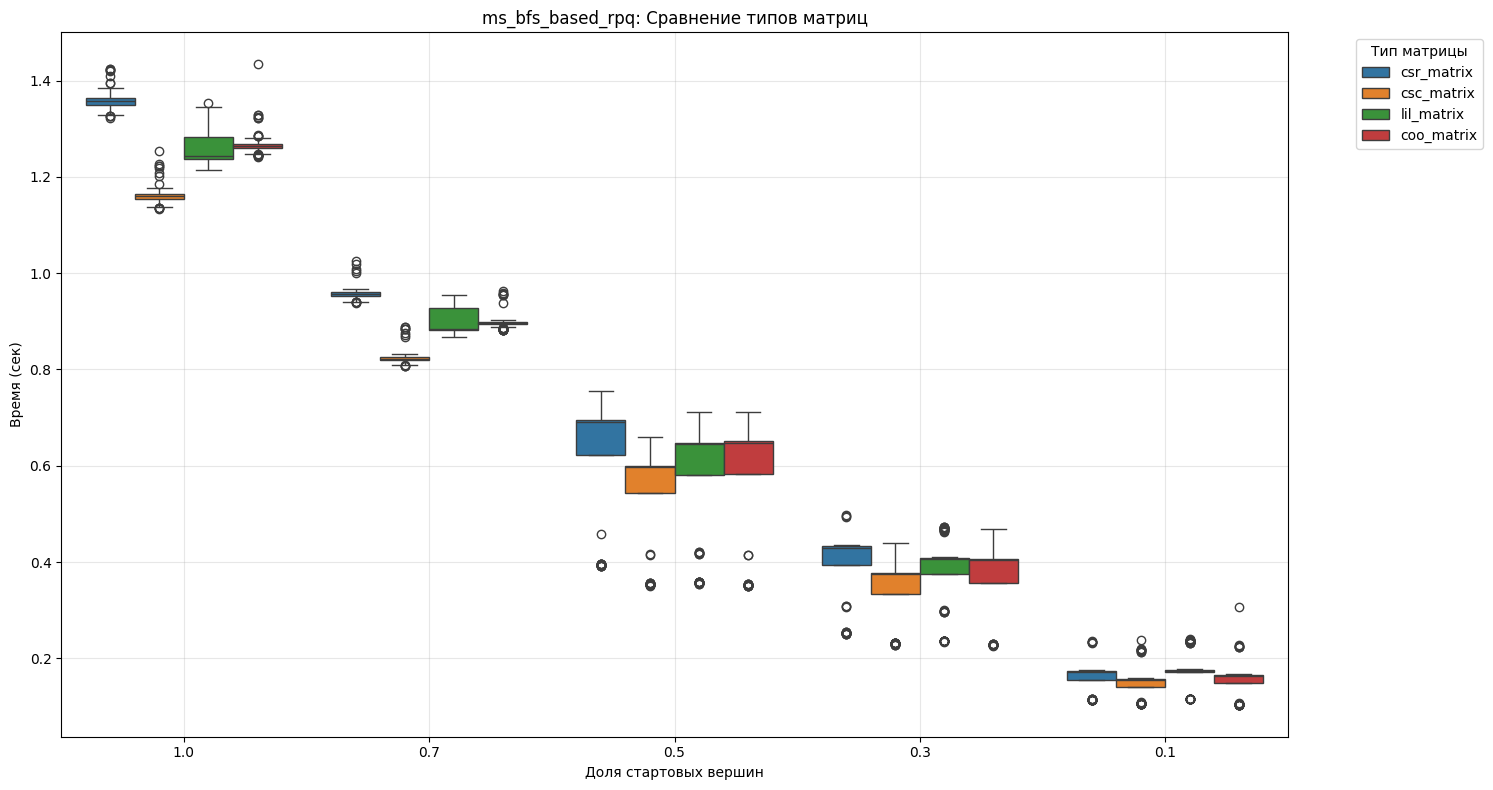

count      mean       std       min       max  \
fraction matrix_type                                                  
0.1      coo_matrix     100  0.154869  0.035119  0.103898  0.306707   
         csc_matrix     100  0.150067  0.031331  0.105435  0.238003   
         csr_matrix     100  0.162002  0.031210  0.113226  0.235403   
         lil_matrix     100  0.174341  0.039976  0.114743  0.239337   
0.3      coo_matrix     100  0.364480  0.080312  0.226462  0.468107   
         csc_matrix     100  0.342715  0.066899  0.228003  0.438841   
         csr_matrix     100  0.389455  0.076817  0.250712  0.498058   
         lil_matrix     100  0.379440  0.076693  0.235003  0.472772   
0.5      coo_matrix     100  0.577771  0.128681  0.351146  0.712494   
         csc_matrix     100  0.539561  0.105765  0.350880  0.659013   
         csr_matrix     100  0.619689  0.130275  0.391396  0.754663   
         lil_matrix     100  0.587880  0.127006  0.355058  0.711741   
0.7      coo_matrix     100  0.897611  0.016775  0.881359  0.962163   
         csc_matrix     100  0.825265  0.017515  0.806492  0.889145   
         csr_matrix     100  0.957701  0.014765  0.939047  1.026132   
         lil_matrix     100  0.896533  0.027819  0.866962  0.954809   
1.0      coo_matrix     100  1.267396  0.023800  1.242084  1.433550   
         csc_matrix     100  1.161835  0.020239  1.133840  1.252958   
         csr_matrix     100  1.358194  0.021493  1.321524  1.424824   
         lil_matrix     100  1.256065  0.031799  1.215075  1.353638   

                     variation_coeff        CI  normal  outliers  
fraction matrix_type                                              
0.1      coo_matrix           22.68%  0.006968   False        32  
         csc_matrix           20.88%  0.006217   False        35  
         csr_matrix           19.27%  0.006193   False        31  
         lil_matrix           22.93%  0.007932   False        44  
0.3      coo_matrix           22.03%  0.015936   False        25  
         csc_matrix           19.52%  0.013274   False        25  
         csr_matrix           19.72%  0.015242   False        28  
         lil_matrix           20.21%  0.015218   False        42  
0.5      coo_matrix           22.27%  0.025533   False        25  
         csc_matrix           19.60%  0.020986   False        25  
         csr_matrix           21.02%  0.025849   False        25  
         lil_matrix           21.60%  0.025201   False        25  
0.7      coo_matrix            1.87%  0.003329   False        30  
         csc_matrix            2.12%  0.003475   False        12  
         csr_matrix            1.54%  0.002930   False        10  
         lil_matrix            3.10%  0.005520   False         0  
1.0      coo_matrix            1.88%  0.004722   False        23  
         csc_matrix            1.74%  0.004016   False        13  
         csr_matrix            1.58%  0.004265   False        12  
         lil_matrix            2.53%  0.006310   False         1

In [655]:
wine_msbfs_df = show_stat_RQ1("ms_bfs_based_rpq", "wine", main_results_df)
wine_msbfs_df

[2025-10-14 17:32:49]>INFO>Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-10-14 17:32:49]>INFO>Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



Наибольшее среднее по долям стартовых вершин:
Доля 1.0: csc_matrix (1.247567 сек) - выигрыш относительно худшего 14.47%
Доля 0.7: csc_matrix (0.877833 сек) - выигрыш относительно худшего 14.07%
Доля 0.5: csc_matrix (0.649166 сек) - выигрыш относительно худшего 13.66%
Доля 0.3: csc_matrix (0.413496 сек) - выигрыш относительно худшего 12.66%
Доля 0.1: csc_matrix (0.154477 сек) - выигрыш относительно худшего 9.74%


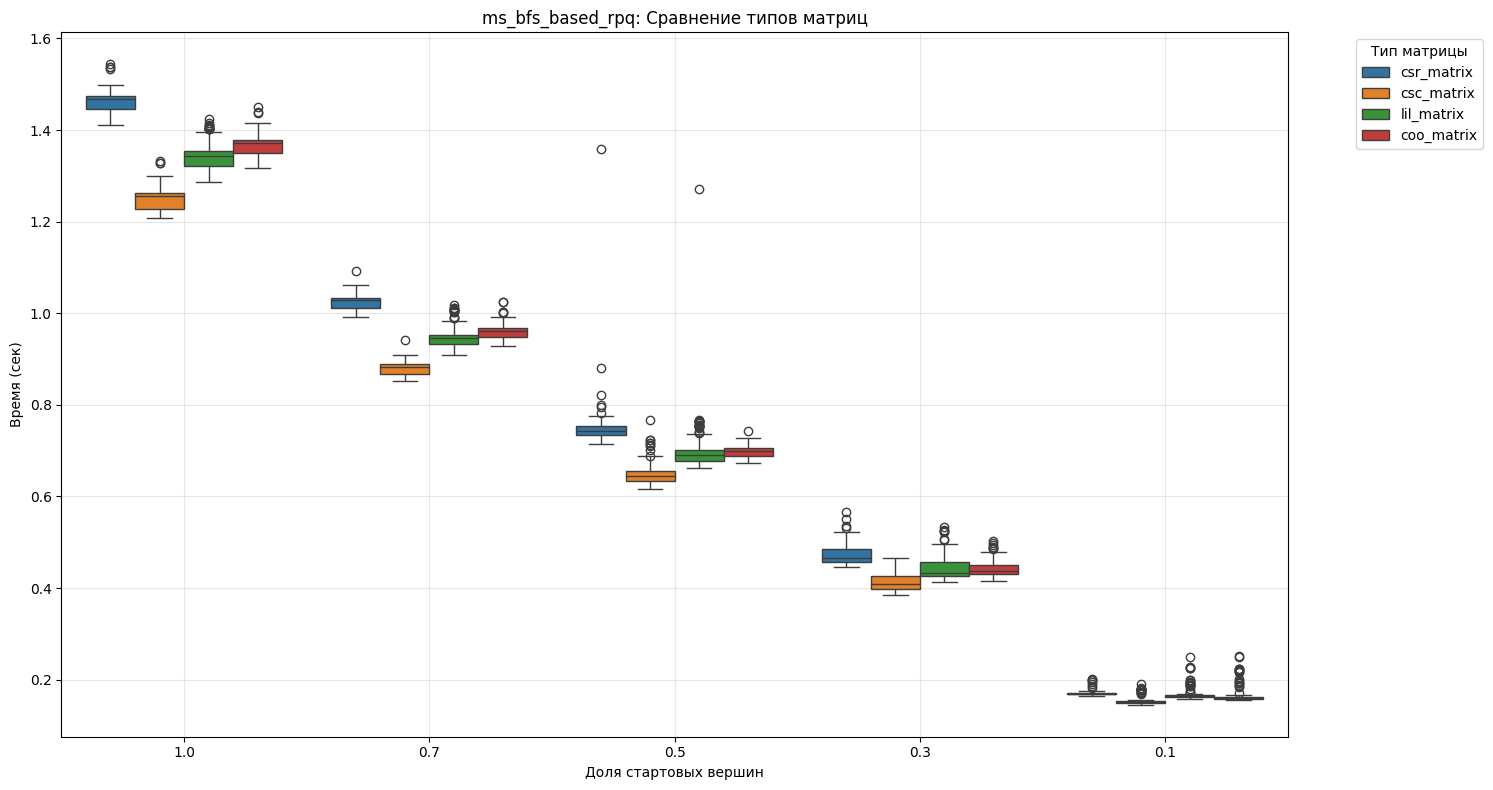

count      mean       std       min       max  \
fraction matrix_type                                                  
0.1      coo_matrix     100  0.168597  0.021052  0.155332  0.250992   
         csc_matrix     100  0.154477  0.010711  0.145287  0.190824   
         csr_matrix     100  0.171143  0.007410  0.164237  0.202023   
         lil_matrix     100  0.170584  0.017086  0.158823  0.250153   
0.3      coo_matrix     100  0.443127  0.019419  0.416032  0.502350   
         csc_matrix     100  0.413496  0.019212  0.384435  0.466693   
         csr_matrix     100  0.473445  0.022857  0.444993  0.567076   
         lil_matrix     100  0.445235  0.029563  0.413002  0.532827   
0.5      coo_matrix     100  0.698077  0.013421  0.672714  0.743296   
         csc_matrix     100  0.649166  0.025897  0.616349  0.765916   
         csr_matrix     100  0.751847  0.065122  0.715161  1.359514   
         lil_matrix     100  0.704863  0.064604  0.661145  1.272063   
0.7      coo_matrix     100  0.958849  0.018398  0.928707  1.024080   
         csc_matrix     100  0.877833  0.015641  0.852092  0.942229   
         csr_matrix     100  1.021618  0.017768  0.990855  1.091772   
         lil_matrix     100  0.949107  0.027400  0.908574  1.017358   
1.0      coo_matrix     100  1.364747  0.026078  1.316992  1.451009   
         csc_matrix     100  1.247567  0.025492  1.208606  1.332884   
         csr_matrix     100  1.458569  0.028377  1.411889  1.543536   
         lil_matrix     100  1.342495  0.033497  1.285859  1.424664   

                     variation_coeff        CI  normal  outliers  
fraction matrix_type                                              
0.1      coo_matrix           12.49%  0.004177   False        18  
         csc_matrix            6.93%  0.002125   False        17  
         csr_matrix            4.33%  0.001470   False         8  
         lil_matrix           10.02%  0.003390   False        21  
0.3      coo_matrix            4.38%  0.003853   False         7  
         csc_matrix            4.65%  0.003812   False         0  
         csr_matrix            4.83%  0.004535   False         4  
         lil_matrix            6.64%  0.005866   False         7  
0.5      coo_matrix            1.92%  0.002663   False         1  
         csc_matrix            3.99%  0.005139   False         9  
         csr_matrix            8.66%  0.012922   False         6  
         lil_matrix            9.17%  0.012819   False        19  
0.7      coo_matrix            1.92%  0.003651   False         5  
         csc_matrix            1.78%  0.003103   False         1  
         csr_matrix            1.74%  0.003526   False         1  
         lil_matrix            2.89%  0.005437   False        13  
1.0      coo_matrix            1.91%  0.005175   False         3  
         csc_matrix            2.04%  0.005058   False         3  
         csr_matrix            1.95%  0.005631   False         4  
         lil_matrix            2.50%  0.006647   False        11

In [656]:
funding_msbfs_df = show_stat_RQ1("ms_bfs_based_rpq", "funding", main_results_df)
funding_msbfs_df

##### Ответ на RQ1 для `ms_bfs_based_rpq`
Во всех экспериментах для всех графов `csc_matrix` показала значительное преимущество над другими представлениями. Выигрыш -- от 9,27% до 14,47%.

### RQ2



In [663]:
def compare_algorithms_RQ2(df, gname):
    plt.figure(figsize=(14, 6))

    algorithm_styles = {
        "tensor_based_rpq": {
            "color": "blue",
            "marker": "o",
            "linestyle": "-",
            "linewidth": 2,
        },
        "ms_bfs_based_rpq": {
            "color": "red",
            "marker": "s",
            "linestyle": "--",
            "linewidth": 2,
        },
    }

    for algo in ALGORITHMS:
        algo = algo.__name__
        dfg = df[(df["algorithm"] == f"{algo}") & (df["graph"] == f"{gname}")].copy()

        time_by_fraction_df = (
            dfg.groupby("fraction")["time"].mean().sort_index(ascending=False)
        )

        style = algorithm_styles.get(algo, {})
        plt.plot(
            time_by_fraction_df.index,
            time_by_fraction_df.values,
            label=algo,
            marker=style.get("marker", "o"),
            linestyle=style.get("linestyle", "-"),
            linewidth=style.get("linewidth", 2),
            color=style.get("color", None),
            markersize=8,
        )

    plt.title(
        f"Сравнение времени работы алгоритмов на графе {gname}",
        fontsize=16,
        fontweight="bold",
    )
    plt.xlabel("Доля стартовых вершин", fontsize=12)
    plt.ylabel("Среднее время выполнения (сек)", fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

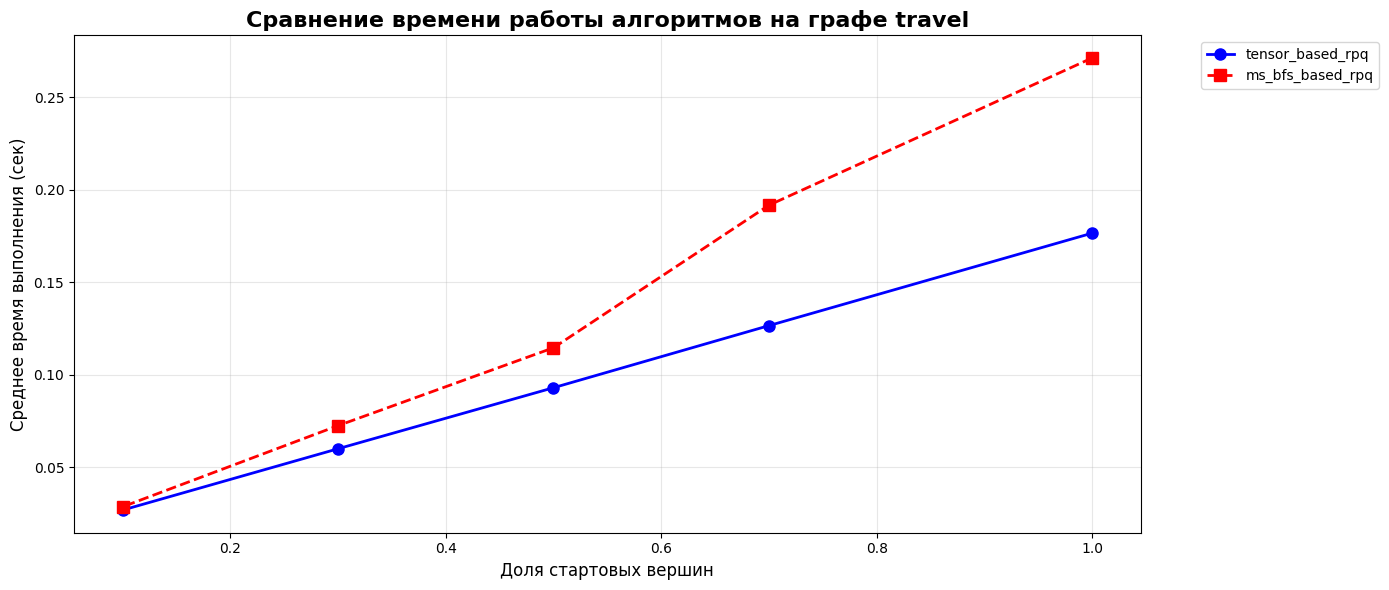

In [664]:
compare_algorithms_RQ2(main_results_df, "travel")

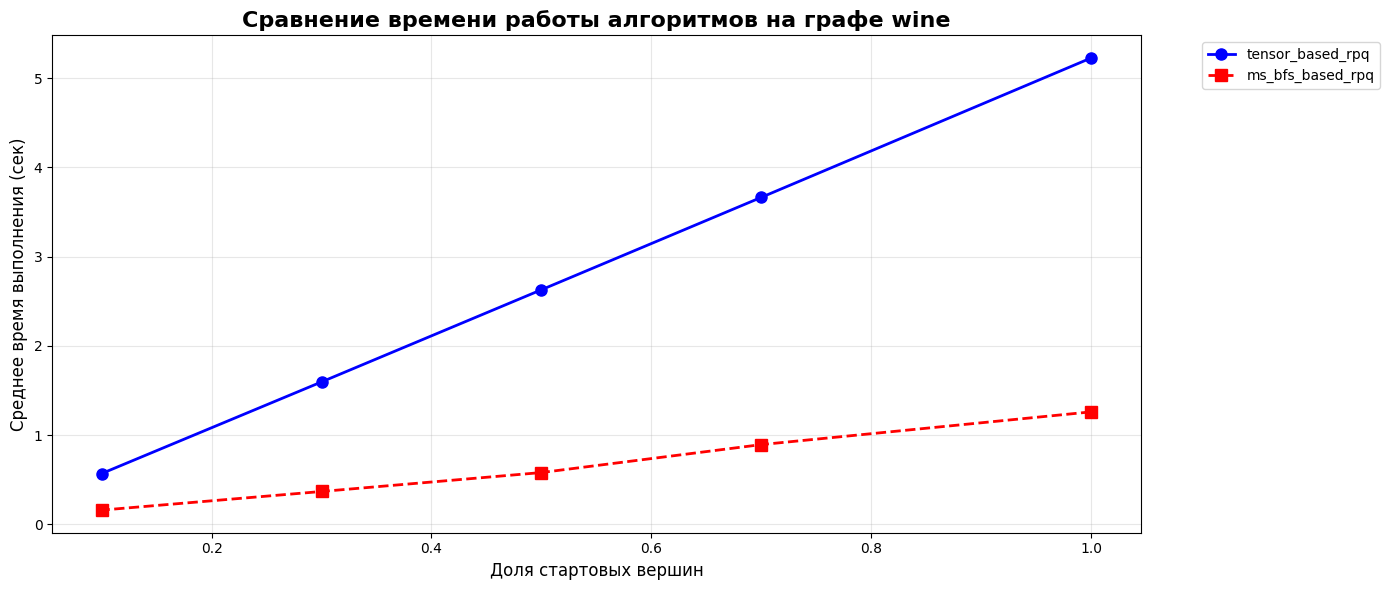

In [665]:
compare_algorithms_RQ2(main_results_df, "wine")

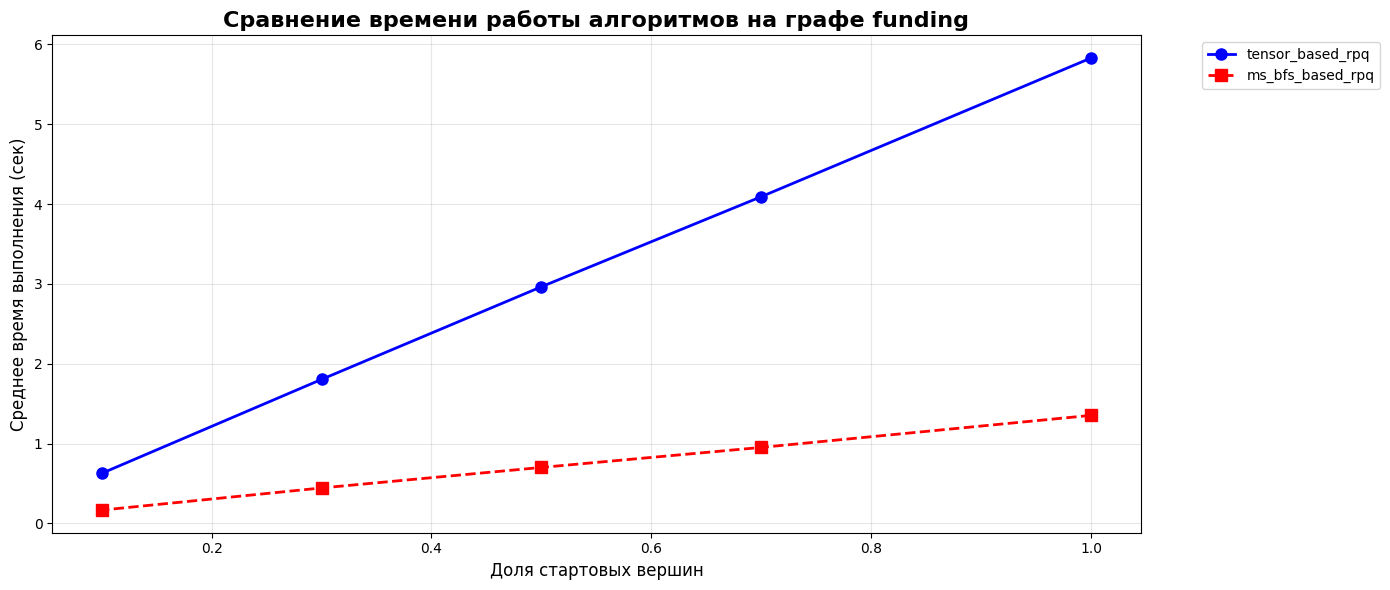

In [666]:
compare_algorithms_RQ2(main_results_df, "funding")

##### Ответ на RQ2 
Все кривые монотонно возрастают: чем больше доля стартовых вершин, тем больше время выполнения алгоритмов. Это означает, что стратегия вычисления для всех пар вершин (эквивалентная доле 1 стартовых вершин от всех вершин) никогда не превосходит по скорости прямое вычисление для подмножества произвольного размера.